# Drug Traffiking experiment: base model

This notebooks contains the data processing, building and training part of the model used for the base iteration of the drug traffiking experiment. 

In [1]:
import shap
import random
import numpy as np
import pandas as pd
from keras import layers
from tensorflow import keras
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from witwidget.notebook.visualization import WitWidget, WitConfigBuilder

## Functions and Utils

In [2]:
# Converts a dataframe column into a column of 0's and 1's based on the provided test.
# Used to force label columns to be numeric for binary classification using a TF estimator.
def make_label_column_numeric(df, label_column, test):
  df[label_column] = np.where(test(df[label_column]), 1, 0)

def minmax_scaler(data):
  scaler = MinMaxScaler()
  scaled = scaler.fit_transform(data)
  return scaled

def process_data(data):
  x = data.loc[:, data.columns != 'Tipo salida 2']
  y = data['Tipo salida 2']

  x_cat = x[['Region', 'Defensor', 'Desarrollo','extranjero']]
  x_cat['Region'] = label_encoder.fit_transform(x_cat['Region'])
  x_cat['Defensor'] = label_encoder.fit_transform(x_cat['Defensor'])
  x_cat['Desarrollo'] = label_encoder.fit_transform(x_cat['Desarrollo'])
  x_cat['extranjero'] = label_encoder.fit_transform(x_cat['extranjero'])

  x_num = x.loc[:, ~x.columns.isin(x_cat.columns)]

  x_norm = minmax_scaler(x_num)
  x_norm = pd.DataFrame(x_norm, columns = x_num.columns)

  x_norm.reset_index(drop=True, inplace=True)
  x_cat.reset_index(drop=True, inplace=True)

  x_fin = pd.concat([x_norm, x_cat], axis = 1)
  #y_fin = label_encoder.fit_transform(y)

  return x_fin

def custom_predict(examples_to_infer):

  preds = model1.predict(model_inputs)
  preds = [[1 - pred[0], pred[0]] for pred in preds]
  return preds

## Importing data and pre-processing
data: dataset using "age" as a simulated variable with a normal distribution

data_2: dataset using "age" as a simulated variable with a uniform distribution

In [3]:
path = r'traficoDrogas.csv'
data = pd.read_csv(path)

## Cambiando las dos RM a una sola

data['Región (tribunal)']=data['Región (tribunal)'].replace('Metropolitana Sur','Metropolitana')
data['Región (tribunal)']=data['Región (tribunal)'].replace('Metropolitana Norte','Metropolitana')

## Sacar filas erróneas

data.drop(16690, inplace=True)
data.drop(16691, inplace=True)

In [4]:
## Agregar variable edad: se prueban con distribución normal y uniforme (estudio drogas SENDA 2020)

data['age_uniform'] = np.nan

## Rango de edades basado en el informe
edad_min = 18
edad_max = 65

mu = 27 ## Edad promedio entre 18 y 34 años (concentran la mayoría de consumo de drogas)
sigma = 8
random.seed(23)

for i in range(len(data)):
    data['age_uniform'][i] = round(np.random.uniform(18, 65))

## Agregar variable extranjero

data['foreigner'] = np.nan

for i in range(len(data)):
    if data['P.S. Expulsión'][i] == 'N':
        data['foreigner'][i] = 'no'
    else:
        data['foreigner'][i] = 'yes'

/var/folders/dv/yyl2yv_j3hl4xyrt3r2qmh4h0000gn/T/ipykernel_52329/1496689438.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['age_uniform'][i] = round(np.random.uniform(18, 65))
/var/folders/dv/yyl2yv_j3hl4xyrt3r2qmh4h0000gn/T/ipykernel_52329/1496689438.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['age_uniform'][i] = round(np.random.uniform(18, 65))
/var/folders/dv/yyl2yv_j3hl4xyrt3r2qmh4h0000gn/T/ipykernel_52329/1496689438.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16690 entries, 0 to 16689
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Región (tribunal)       16690 non-null  object 
 1   Defensor                16690 non-null  object 
 2   Imputado                16690 non-null  object 
 3   CAUSAIMPUTADOID         16690 non-null  float64
 4   RUD                     16690 non-null  object 
 5   Fecha término           16690 non-null  object 
 6   Audiencias efectivas    16690 non-null  float64
 7   Delito                  16690 non-null  object 
 8   Grado desarrollo        16690 non-null  object 
 9   Forma término           16690 non-null  object 
 10  Forma término SIGDP     16690 non-null  object 
 11  Pena solicitada por MP  9285 non-null   object 
 12  Tramo ID MP             9038 non-null   float64
 13  Años MP                 8915 non-null   float64
 14  Días MP                 3659 non-null   flo

In [6]:
data.drop(data.columns[[2, 3, 4, 5, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]], axis=1, inplace=True)
data.rename(columns = {'Región (tribunal)':'region', 
                       'Grado desarrollo':'crime_stage',
                       'Defensor': 'barrister',
                       'Audiencias efectivas': 'effective_hearings'}, inplace = True)

## Data Transformations

In [7]:
x1 = data.loc[:, ~data.columns.isin(['Tipo salida 1', 'Tipo salida 2'])]
y1 = data.loc[:, data.columns.isin(['Tipo salida 1', 'Tipo salida 2'])]

In [8]:
x_train1, x_test1, y_train1, y_test1 = train_test_split(x1, y1['Tipo salida 2'], test_size=0.3, random_state = 23)

## Del set de entrenamiento, se desprenden 1000 datos para generar un dataset de validación

x_val1 = x_train1[-1000:]
y_val1 = y_train1[-1000:]

In [9]:
x_cat_train = x_train1[['region', 'barrister', 'crime_stage','foreigner']]
x_cat_test = x_test1[['region', 'barrister', 'crime_stage','foreigner']]
x_cat_val = x_val1[['region', 'barrister', 'crime_stage','foreigner']]

In [10]:
label_encoder = preprocessing.LabelEncoder()

x_cat_train['region'] = label_encoder.fit_transform(x_cat_train['region'])
x_cat_train['barrister'] = label_encoder.fit_transform(x_cat_train['barrister'])
x_cat_train['crime_stage'] = label_encoder.fit_transform(x_cat_train['crime_stage'])
x_cat_train['foreigner'] = label_encoder.fit_transform(x_cat_train['foreigner'])

x_cat_test['region'] = label_encoder.fit_transform(x_cat_test['region'])
x_cat_test['barrister'] = label_encoder.fit_transform(x_cat_test['barrister'])
x_cat_test['crime_stage'] = label_encoder.fit_transform(x_cat_test['crime_stage'])
x_cat_test['foreigner'] = label_encoder.fit_transform(x_cat_test['foreigner'])

x_cat_val['region'] = label_encoder.fit_transform(x_cat_val['region'])
x_cat_val['barrister'] = label_encoder.fit_transform(x_cat_val['barrister'])
x_cat_val['crime_stage'] = label_encoder.fit_transform(x_cat_val['crime_stage'])
x_cat_val['foreigner'] = label_encoder.fit_transform(x_cat_val['foreigner'])

/var/folders/dv/yyl2yv_j3hl4xyrt3r2qmh4h0000gn/T/ipykernel_52329/2088860359.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_cat_train['region'] = label_encoder.fit_transform(x_cat_train['region'])
/var/folders/dv/yyl2yv_j3hl4xyrt3r2qmh4h0000gn/T/ipykernel_52329/2088860359.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_cat_train['barrister'] = label_encoder.fit_transform(x_cat_train['barrister'])
/var/folders/dv/yyl2yv_j3hl4xyrt3r2qmh4h0000gn/T/ipykernel_52329/2088860359.py:5: SettingWithCopyWar

In [11]:
x_num_train = x_train1.loc[:, ~x_train1.columns.isin(x_cat_train.columns)]
x_num_test = x_test1.loc[:, ~x_test1.columns.isin(x_cat_test.columns)]
x_num_val = x_val1.loc[:, ~x_val1.columns.isin(x_cat_val.columns)]

In [12]:
x_norm_train = minmax_scaler(x_num_train)
x_norm_train = pd.DataFrame(x_norm_train, columns = x_num_train.columns)

x_norm_test = minmax_scaler(x_num_test)
x_norm_test = pd.DataFrame(x_norm_test, columns = x_num_test.columns)

x_norm_val = minmax_scaler(x_num_val)
x_norm_val = pd.DataFrame(x_norm_val, columns = x_num_val.columns)

In [13]:
x_norm_train.reset_index(drop=True, inplace=True)
x_cat_train.reset_index(drop=True, inplace=True)

x_norm_test.reset_index(drop=True, inplace=True)
x_cat_test.reset_index(drop=True, inplace=True)

x_norm_val.reset_index(drop=True, inplace=True)
x_cat_val.reset_index(drop=True, inplace=True)

In [14]:
x_train_fin = pd.concat([x_norm_train, x_cat_train], axis = 1)
x_test_fin = pd.concat([x_norm_test, x_cat_test], axis = 1)
x_val_fin = pd.concat([x_norm_val, x_cat_val], axis = 1)

y_train_fin = label_encoder.fit_transform(y_train1)
y_test_fin = label_encoder.fit_transform(y_test1)
y_val_fin = label_encoder.fit_transform(y_val1)

## Building the model

In [15]:
print('Training Features Shape:', x_train_fin.shape)
print('Training Labels Shape:', y_train_fin.shape)

print('Testing Features Shape:', x_test_fin.shape)
print('Testing Labels Shape:', y_test_fin.shape)

Training Features Shape: (11683, 6)
Training Labels Shape: (11683,)
Testing Features Shape: (5007, 6)
Testing Labels Shape: (5007,)


In [16]:
num_classes1 = 1
num_features1 = x_train_fin.shape[1]
num_output1 = 1

num_layers_01 = 13
num_layers_11 = 6

epochs1 = 70
learning_rate1 = 0.01
batch_size1 = 1024

In [17]:
inputs1 = keras.Input(shape = (num_features1,), name = "data")
x11 = layers.Dense(num_layers_01, activation = "sigmoid", name = "dense_1")(inputs1)
x21 = layers.Dense(num_layers_11, activation = "sigmoid", name = "dense_2")(x11)
outputs1 = layers.Dense(num_output1, activation = "sigmoid", name = "predictions")(x21)

model1 = keras.Model(inputs = inputs1, outputs = outputs1)

## Training and metrics

In [18]:
## Compilando el modelo

model1.compile(
    optimizer = keras.optimizers.Adam(learning_rate = learning_rate1),
    loss = keras.losses.BinaryCrossentropy(from_logits = False),
    metrics = [keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.BinaryAccuracy()],
)

In [19]:
# Entrenando el modelo

training1 = model1.fit(
    x_train_fin,
    y_train_fin,
    batch_size = batch_size1,
    epochs = epochs1,
    validation_data=(x_val_fin, y_val_fin)
)

Epoch 1/70
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - binary_accuracy: 0.5322 - loss: 0.7632 - precision: 0.5322 - recall: 1.0000 - val_binary_accuracy: 0.5500 - val_loss: 0.6901 - val_precision: 0.5500 - val_recall: 1.0000
Epoch 2/70
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.5208 - loss: 0.6917 - precision: 0.5363 - recall: 0.7943 - val_binary_accuracy: 0.4500 - val_loss: 0.6963 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/70
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.4731 - loss: 0.6944 - precision: 0.4530 - recall: 0.2594 - val_binary_accuracy: 0.5580 - val_loss: 0.6879 - val_precision: 0.5550 - val_recall: 0.9909
Epoch 4/70
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.5345 - loss: 0.6907 - precision: 0.5346 - recall: 0.9978 - val_binary_accuracy: 0.5500 - val_loss: 0.6859 - val_precision: 0.5500 - val_recall: 1.0000
Epoch 5/70
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.5362 - loss: 0.6899 - precision:

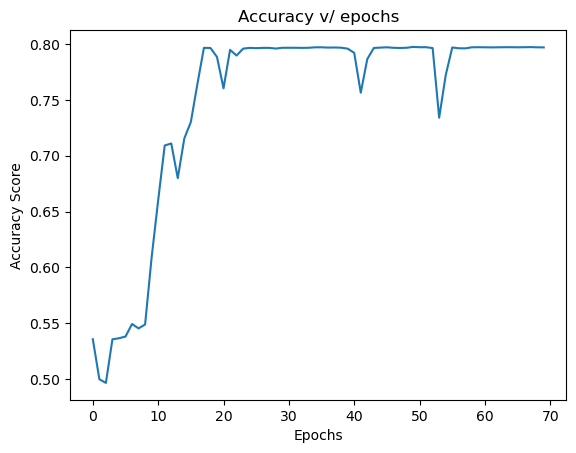

In [20]:
training1.history['binary_accuracy']
training1.epoch

plt.plot(training1.epoch, training1.history['binary_accuracy'])
plt.title('Accuracy v/ epochs')
plt.ylabel('Accuracy Score')
plt.xlabel('Epochs')
plt.show()

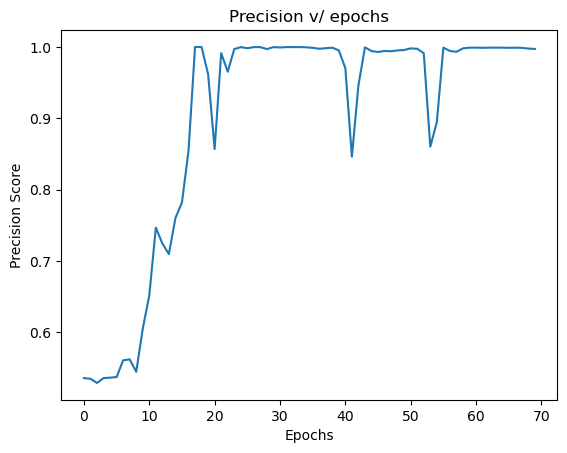

In [21]:
training1.history['precision']
plt.plot(training1.epoch, training1.history['precision'])
plt.title('Precision v/ epochs')
plt.ylabel('Precision Score')
plt.xlabel('Epochs')
plt.show()

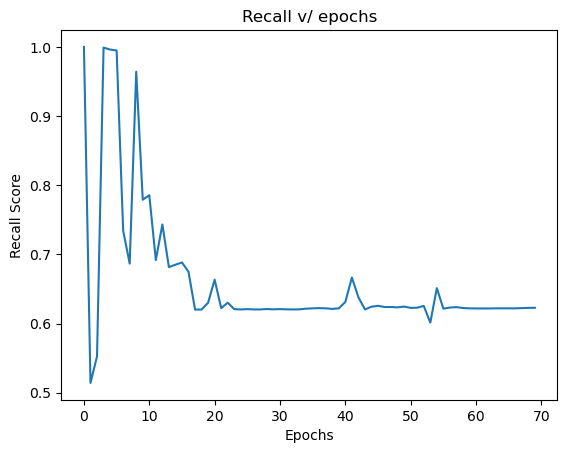

In [22]:
training1.history['recall']
plt.plot(training1.epoch, training1.history['recall'])
plt.title('Recall v/ epochs')
plt.ylabel('Recall Score')
plt.xlabel('Epochs')
plt.show()

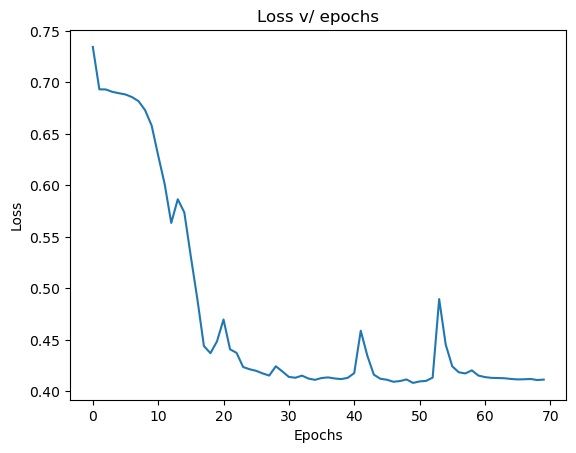

In [23]:
training1.history['loss']
plt.plot(training1.epoch, training1.history['loss'])
plt.title('Loss v/ epochs')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.show()

## Model Evaluation

In [24]:
## Evaluando el modelo

results1 = model1.evaluate(x_test_fin, y_test_fin, batch_size = 1024)
print("test loss, test acc, test prec, test recall:", results1)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7836 - loss: 0.4273 - precision: 0.9951 - recall: 0.5993 
test loss, test acc, test prec, test recall: [0.430101603269577, 0.9937694668769836, 0.5949272513389587, 0.7811064720153809]


In [25]:
## Generando predicciones

predict_train1 = (model1.predict(x_train_fin) > 0.5).astype(int)
predict_test1 = (model1.predict(x_test_fin) > 0.5).astype(int)

366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 291us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 240us/step


In [26]:
## Matriz de confusión para dataset de entrenamiento

print(confusion_matrix(y_train_fin,predict_train1))
print(classification_report(y_train_fin,predict_train1))

[[5414    9]
 [2360 3900]]
              precision    recall  f1-score   support

           0       0.70      1.00      0.82      5423
           1       1.00      0.62      0.77      6260

    accuracy                           0.80     11683
   macro avg       0.85      0.81      0.79     11683
weighted avg       0.86      0.80      0.79     11683



In [27]:
## Matriz de confusión para dataset de prueba

print(confusion_matrix(y_test_fin,predict_test1))
print(classification_report(y_test_fin,predict_test1))

[[2316   10]
 [1086 1595]]
              precision    recall  f1-score   support

           0       0.68      1.00      0.81      2326
           1       0.99      0.59      0.74      2681

    accuracy                           0.78      5007
   macro avg       0.84      0.80      0.78      5007
weighted avg       0.85      0.78      0.77      5007



## Saving results and model

In [28]:
test_results = pd.DataFrame(predict_test1, columns=['score'])

x_test1_alt = x_test1.reset_index(drop=True)
y_test1_alt = y_test1.reset_index(drop=True)

test = pd.concat([x_test1_alt, test_results, pd.DataFrame(y_test_fin)], axis = 1)

path2 = r'outputs/preds_dt_base_uniform.csv'
test.to_csv(path2)

In [29]:
model1.save('outputs/dt_base_uniform.keras')

## SHAP Values

In [30]:
explainer = shap.Explainer(model1, x_train_fin.values[:])
shap_values = explainer(x_train_fin.values[:])
shap_values

ExactExplainer explainer: 11684it [00:27, 274.83it/s]                           


.values =
array([[-1.52455767e-05, -1.75388861e-03,  2.96244105e-03,
         1.28103024e-02,  0.00000000e+00,  4.33171109e-01],
       [-6.00348587e-05, -1.76024203e-03, -1.69777437e-03,
        -4.29804796e-03,  0.00000000e+00, -2.60323959e-01],
       [-5.61241060e-05,  1.94158713e-03,  7.98428555e-05,
         1.07488185e-02,  0.00000000e+00,  4.34198095e-01],
       ...,
       [-5.75486049e-05,  5.50457640e-03,  1.18182012e-02,
         2.35591549e-02,  0.00000000e+00, -2.52886485e-01],
       [ 6.98501887e-04, -1.94854128e-03, -1.54724111e-02,
         1.16021377e-03,  0.00000000e+00, -2.60980199e-01],
       [-1.72475388e-04, -7.85689761e-03, -3.94335914e-03,
         1.31218282e-02,  0.00000000e+00, -2.58197564e-01]])

.base_values =
array([[0.55137516],
       [0.55137516],
       [0.55137516],
       ...,
       [0.55137516],
       [0.55137516],
       [0.55137516]])

.data =
array([[9.45945946e-02, 6.59574468e-01, 1.30000000e+01, 3.90000000e+01,
        0.00000000e+00, 1.0

In [31]:
shap_values.feature_names = list(x_train_fin.columns)

In [32]:
shap_df = pd.DataFrame(shap_values.values, columns=shap_values.feature_names)

# Calcular el valor absoluto y luego el promedio para cada característica
shap_abs_avg = shap_df.abs().mean()
shap_avg = shap_df.mean()
shap_max = shap_df.max()
shap_min= shap_df.min()

print('Media absoluta: ', '\n\n', shap_abs_avg)
print('----------------------------------')
print('Media: ', '\n\n', shap_avg)
print('----------------------------------')
print('Máximo: ', '\n\n', shap_max)
print('----------------------------------')
print('Mínimo: ', '\n\n', shap_min)

Media absoluta:  

 effective_hearings    0.000170
age_uniform           0.004415
region                0.004560
barrister             0.012491
crime_stage           0.000138
foreigner             0.319639
dtype: float64
----------------------------------
Media:  

 effective_hearings   -0.000048
age_uniform           0.000399
region                0.000544
barrister             0.001426
crime_stage           0.000138
foreigner            -0.025289
dtype: float64
----------------------------------
Máximo:  

 effective_hearings    0.017191
age_uniform           0.037271
region                0.066324
barrister             0.296686
crime_stage           0.475151
foreigner             0.462349
dtype: float64
----------------------------------
Mínimo:  

 effective_hearings   -0.015006
age_uniform          -0.053595
region               -0.136700
barrister            -0.061175
crime_stage           0.000000
foreigner            -0.271499
dtype: float64


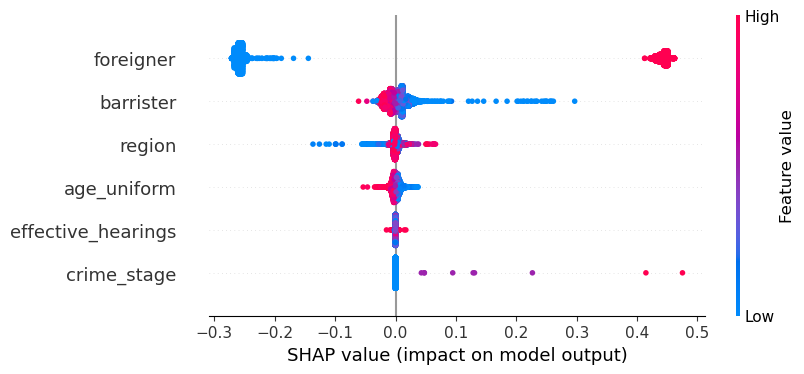

In [33]:
fig, ax = plt.subplots()
shap.plots.beeswarm(shap_values)

In [34]:
fig.savefig("outputs/dt_base_uniform_shap.pdf", bbox_inches="tight", format="pdf")  # o "shap_plot.svg" para formato SVG

## What if Tool

In [35]:
num_datapoints = 5007
tool_height_in_px = 750

examples_labels = pd.concat([x_test_fin.reset_index(drop=True), pd.DataFrame(y_test_fin, columns = ['Tipo salida 2']).reset_index(drop=True)], axis=1)
columns_not_for_model_input = [examples_labels.columns.get_loc('Tipo salida 2')]

examples_wit = examples_labels.values.tolist()
column_names = examples_labels.columns.tolist()

model_inputs = np.delete(np.array(examples_wit[:num_datapoints]), columns_not_for_model_input, axis=1)

In [36]:
# Setup the tool with the test examples and the trained classifier

config_builder = WitConfigBuilder(examples_wit[:num_datapoints],column_names).set_custom_predict_fn(custom_predict).set_target_feature('Tipo salida 2')
WitWidget(config_builder, height=tool_height_in_px)

WitWidget(config={'model_type': 'classification', 'label_vocab': [], 'feature_names': ['effective_hearings', '…